# Low price to FCF strategy evaluation

Is simply buying very low price to FCF (TTM) a good strategy?

In [35]:
from research.interday_trading import InterdayTrading
from fmp_data import Dataset, FMPPriceLoader

pl = FMPPriceLoader()
t = InterdayTrading('2024-01-02', '2024-01-15')

In [ ]:
start_date = '2013-01-02'
end_date = (pd.to_datetime(start_date) + pd.DateOffset(months=3)).strftime('%Y-%m-%d')

d = t.build_features_for_date(pd.to_datetime(start_date).date())
x = d
x = d[~d['industry'].str.contains('REIT', case=False, na=False)]
x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4)]

#x = x[(x.min_yoy > 0)]

x['rank'] = x.price_to_fcf
#x = x[x.price >= 10]
sym = x.symbol.to_list()
p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data
y = pd.merge(x, p[['symbol', 'end_price']], on='symbol', how = 'inner')
y['r'] = y.end_price / y.price - 1
spx_r = pl.get_price('^SPX', end_date) / pl.get_price('^SPX', start_date) - 1

print(f"Average return: {y.r.mean()*100:.2f}%")
print(f"SPX return: {spx_r*100:.2f}%")
y[['symbol', 'last_fcf', 'price_to_fcf', 'median_yoy', 'min_yoy', 'last_yoy', 'sector', 'industry', 'rank', 'r']].sort_values('rank').head(20)

2025-04-20 17:13:17,268 - Fetching price data for 5389 stocks on 2010-06-02
2025-04-20 17:13:58,818 - Retrieved prices for 2371 stocks
2025-04-20 17:13:58,820 - Calculating price-to-FCF ratios
2025-04-20 17:13:58,872 - Calculating revenue growth metrics
2025-04-20 17:14:01,282 - Merging feature data
2025-04-20 17:14:01,284 - Adding sector and industry information


Average return: -1.21%


,symbol,last_fcf,price_to_fcf,median_yoy,min_yoy,last_yoy,sector,industry,rank,r
308,TLK,2931.737997,0.001209,0.070494,-0.020732,0.085836,Communication Services,Telecom Services,0.001209,0.191288
143,GRVY,1797.118968,0.004029,0.093327,-0.230790,-0.230790,Communication Services,Electronic Gaming & Multimedia,0.004029,-0.154696
40,BSAC,1553.182360,0.007869,-0.179436,-0.285609,1.283024,Financial Services,Banks - Regional,0.007869,0.372793
11,AKO-A,180.075800,0.020631,-0.189431,-0.478391,-0.263969,Consumer Defensive,Beverages—Non-Alcoholic,0.020631,0.333841
12,AKO-B,180.075800,0.025474,-0.189431,-0.478391,-0.263969,Consumer Defensive,Beverages—Non-Alcoholic,0.025474,0.315432
271,SAR,40.225548,0.050276,-0.517635,-0.577759,-0.459490,Financial Services,Asset Management,0.050276,0.128920
145,GS-PA,42.883562,0.110694,NaN,NaN,NaN,Financial Services,Capital Markets,0.110694,0.123243
258,PTMN,16.444064,0.187659,-0.248341,-0.346053,-0.346053,Financial Services,Asset Management,0.187659,0.067701
56,CHT,24.200513,0.210446,-0.027858,-0.046371,0.026464,Communication Services,Telecom Services,0.210446,0.140916
31,BGC,4.086442,0.322932,-0.006962,-0.043657,0.023442,Financial Services,Capital Markets,0.322932,-0.100559


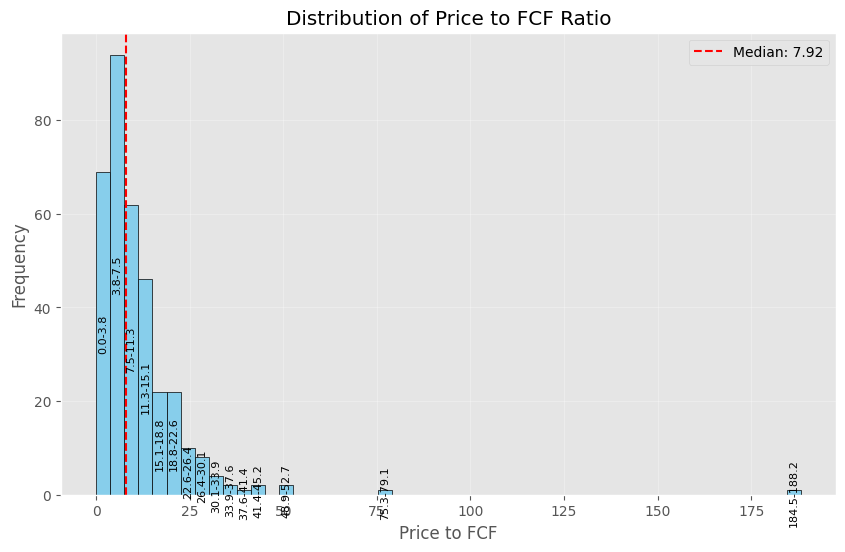

In [42]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(y.price_to_fcf, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=y.price_to_fcf.median(), color='red', linestyle='--', label=f'Median: {y.price_to_fcf.median():.2f}')

# Add text labels showing the range for each bar
for i in range(len(patches)):
    if n[i] > 0:  # Only add text if the bar has data
        plt.text(bins[i] + (bins[i+1]-bins[i])/2, n[i]/2, 
                 f'{bins[i]:.1f}-{bins[i+1]:.1f}', 
                 ha='center', va='center', rotation=90, fontsize=8)

plt.title('Distribution of Price to FCF Ratio')
plt.xlabel('Price to FCF')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/var/folders/wg/v69kcktn0jg6b4sv92_xtcrm0000gp/T/ipykernel_61290/4102888210.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_returns = z.groupby(buckets)['r'].mean().reset_index()


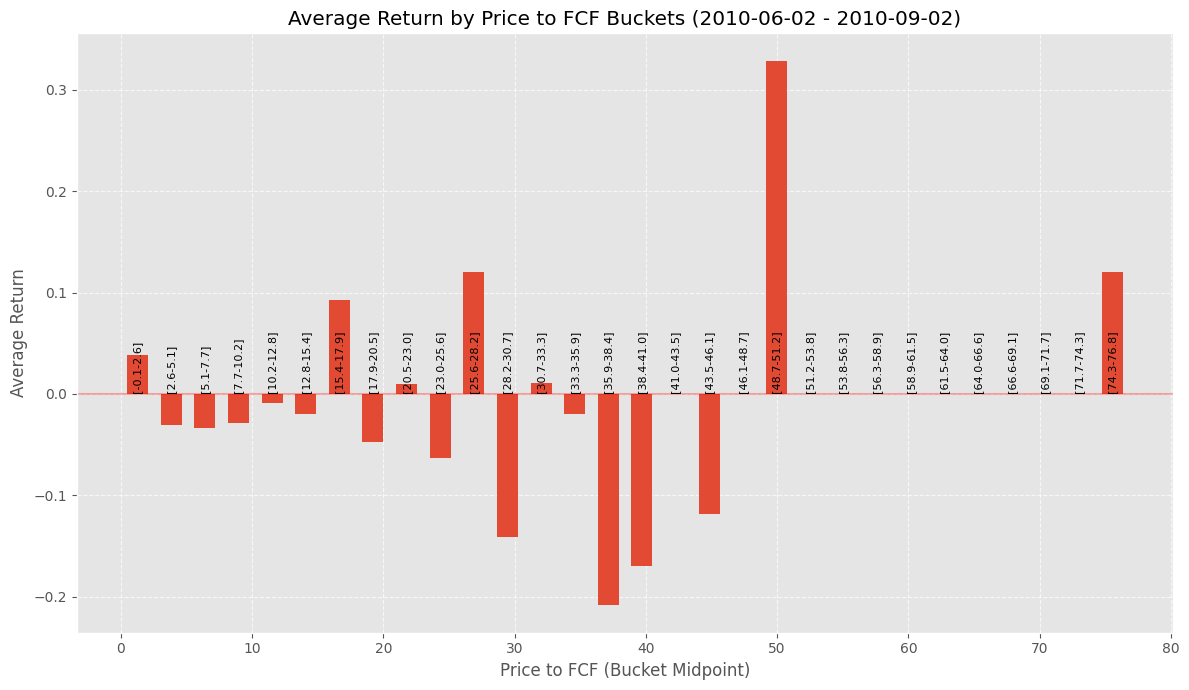

In [43]:
# Filter data to the specified range
z = y[(y.price_to_fcf >= 0.001) & (y.price_to_fcf <= 100)]

# Create 50 buckets
buckets = pd.cut(z.price_to_fcf, bins=30)

# Calculate average return for each bucket
bucket_returns = z.groupby(buckets)['r'].mean().reset_index()

# Get the bucket midpoints for x-axis
bucket_returns['midpoint'] = bucket_returns['price_to_fcf'].apply(lambda x: (x.left + x.right) / 2)

# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(bucket_returns['midpoint'], bucket_returns['r'], width=(100-0.001)/50*0.8)

# Add text labels for bucket boundaries
for i, bar in enumerate(bars):
    bucket = bucket_returns['price_to_fcf'].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, 
             0.001, 
             f'[{bucket.left:.1f}-{bucket.right:.1f}]', 
             ha='center', 
             va='bottom', 
             rotation=90, 
             fontsize=8)

plt.title(f'Average Return by Price to FCF Buckets ({start_date} - {end_date})')
plt.xlabel('Price to FCF (Bucket Midpoint)')
plt.ylabel('Average Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()
